In [1]:
CAM_BASE_DIR = '/media/nico/data/fourthbrain/project/'
CAM16_DIR = CAM_BASE_DIR + 'CAMELYON16/'
GENERATED_DATA = CAM_BASE_DIR + 'output_CAMELYON16/'

In [2]:
MODEL_FINAL = GENERATED_DATA + 'model_final.hdf5'

# Destination to store the heatmaps which we will create in this notebook
HEATMAPS_CAM16_TESTSET = GENERATED_DATA +'test_set_predictions/'

In [15]:
import matplotlib.pyplot as plt 
from preprocessing.datamodel import SlideManager
from preprocessing.processing import split_negative_slide, split_positive_slide, rgb2gray, create_tumor_mask
from generate_tiles import get_otsu_threshold

Reading CAMELYON16 Test Dataset
The main purpose of creating a training dataset as a single HDF5 file was to reduce the time reading the data. This was crucial for training, because we needed to read the same data over and over again while training. Concerning the test dataset, this is not as crucial, because we only need to read every slide once, predicting each tile once, after the training is finished.

So to read the CAMELYON16 test dataset, we can just use the SlideManager class, SlideManager.test_slides attribute and the split_annotated_slides and split_negative_slides methods.

Notes:

We must use the same tile_size we trained our CNN on
We must use the same poi we used to seperate tisse from background
The higher the overlap, the higher resolution our heatmap will have.

Higher overlap dramatically increases prediciton time.
At least half the tile_zizse is suggested to reduce chance dividing smaller tumorous regions and there missclassifying tiles.

In [4]:
mgr = SlideManager(cam16_dir=CAM16_DIR)

### Depending on option chosen in "create-custom-dataset" (option A = level 0) (optopn B = level3)
level = 1 

### 256 for either option as we trained our CNN on 256 tiles
tile_size = 256

### 20% of a tile must contain tissue (in contrast to slide background)
poi = 0.20

### more overlap, higher resolution but increased processing time
overlap = tile_size // 2

When we pass a test slide as parameter to the method create_tumor_mask, a mask will always be returned. If there exists no annotation xml file (because it is a slide without metastatic regions), the mask will just contain nans. This method can be used to manually compare your generated heatmaps with the true tumor area.

In [43]:
slide = mgr.get_slide('test_001')

### some general slide information
print(slide)
print(slide.dimensions)
print(slide.level_dimensions[level])

Slide('test_001', '/media/nico/data/fourthbrain/project/CAMELYON16/test/images/test_001.tif', None, '/media/nico/data/fourthbrain/project/CAMELYON16/test/lesion_annotations/test_001.xml')
(86016, 89600)
(43008, 44800)


(44800, 43008)


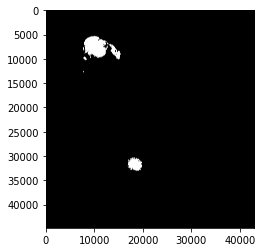

In [44]:
### create tumor mask and show it if exists - in this case test001 has annotations and contains tumors
mask = create_tumor_mask(slide, level=1)
print(mask.shape)
plt.imshow(mask, cmap='gray')

In [45]:
# How to use it when testing a model

In [64]:
from read_tiles import load_color_normalization_values
import numpy as np

In [65]:
threshold = get_otsu_threshold(slide, level)

In [66]:
# color normalization mean and std for each dimension (r,g,b)

In [58]:
mean, std = load_color_normalization_values("CAMELYON16_color_normalization.json")

In [78]:
iter_tiles = split_negative_slide(slide, 
                             level=level, 
                             otsu_threshold=threshold,
                             tile_size=tile_size, 
                             overlap=0,
                             poi_threshold=poi)

In [79]:
tiles, bounds = list(), list()
for tile, box in iter_tiles:
    t = np.empty([tile_size, tile_size, 3])
    for i in [0, 1, 2]:
        t[:, :, i] = (tile[:, :, i] - mean[i]) / std[i]
        tiles.append(t)
        bounds.append(box)

In [82]:
bounds[0]

((22016, 512), (512, 512))

In [81]:
tile.shape

(256, 256, 3)

In [ ]:
# there is something wrong with the tile size (256) and the bound size (512)

In [ ]:
# After classifying each time with model predict, we need to build our own mask picture to be able to compare
# our model with the annotations